## Physics-Informed Neural Networks (PINNs) Practical Exercise
## Solving the 1D Heat Equation using PINNs

#### imports and installations

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

# set seed for reproducibility
torch.manual_seed(42)

## Configure system Parameters 

In [2]:
alpha = 0.001       # original thermal diffusivity [m^2/s]
L     = 1.0        # domain length [m]
T_max = 1     # max time [s]
U_max = 1      # max temperature [°C]
num_domain_points = 1000
num_boundary_points = 100

def system_params(alpha=alpha, L=L, T_max=T_max, U_max=U_max):
    return {'alpha': alpha,'L': L, 'T_max': T_max, 'U_max': U_max}

system_params = system_params()

### Set up initial conditions configuration
#### Consider 2 optional IC setups- sinusoidal and block heat source


In [42]:
# create a sinusoidal distribution initial condition
def i_c_sin(x_initial):
    u_initial = torch.sin(torch.pi * x_initial) 
    return u_initial

# create a block heat source initial condition
def i_c_block(x_initial, width = 0.4, center = 0.4, high_temp = 1.0, low_temp = 0.0):
    # Create mask for points inside the block
    mask = (x_initial >= (center - width/2)) & (x_initial <= (center + width/2))
    # Initialize with low temperature
    u_initial = torch.full_like(x_initial, low_temp)
    # Set high temperature for points inside the block
    u_initial[mask] = high_temp
    
    return u_initial

# generate initial conditions training data
def generate_initial_data(num_boundary_points, initial_condition = i_c_sin):
    x_initial = torch.rand(num_boundary_points, 1, requires_grad=True)
    t_initial = torch.zeros_like(x_initial)
    u_initial = initial_condition(x_initial)
    return x_initial, t_initial, u_initial


### Configure Boundry Conditions & Domain Training points

In [43]:
def generate_boundary_data(num_boundary_points, boundary_value=0):
    # create x_boundary and t_boundary
    x_boundary_0 = torch.zeros(num_boundary_points, 1, requires_grad=True)  # x=0 boundary
    x_boundary_1 = torch.ones(num_boundary_points, 1, requires_grad=True)   # x=1 boundary
    x_boundary = torch.cat([x_boundary_0, x_boundary_1], dim=0)   # combine both boundaries

    t_boundary = torch.rand(num_boundary_points * 2, 1, requires_grad=True)   # random time points to match the boudaries

    u_boundary = torch.full_like(x_boundary, boundary_value) # set the boundary values to the boundary points

    return x_boundary, t_boundary, u_boundary

# Generate a random setup of interior domain points to train the model on
def generate_domain_points(num_domain_points):
    x_domain = torch.rand(num_domain_points, 1, requires_grad = True)
    t_domain = torch.rand(num_domain_points, 1, requires_grad = True)
    
    return x_domain,t_domain

#### Plot IC and BC

In [46]:
def plot_IC_BC(num_domain_points, num_boundary_points, initial_condition=i_c_sin, plot_IC_alone=True):
    # Generate data
    x_domain, t_domain= generate_domain_points(num_domain_points)
    x_boundary, t_boundary, u_boundary = generate_boundary_data(num_boundary_points, boundary_value=0)
    x_initial, t_initial, u_initial = generate_initial_data(num_boundary_points, initial_condition)
    # Convert to numpy arrays
    x_init_np , t_init_np , u_init_np = x_initial.detach().numpy(), t_initial.detach().numpy(), u_initial.detach().numpy()
    x_boundary_np , t_boundary_np , u_boundary_np = x_boundary.detach().numpy(), t_boundary.detach().numpy(), u_boundary.detach().numpy()
    # Unite all x,t,u in one array
    x_np = np.concatenate((x_init_np, x_boundary_np))
    t_np = np.concatenate((t_init_np, t_boundary_np))
    u_np = np.concatenate((u_init_np, u_boundary_np))

    if plot_IC_alone:
        fig = plt.figure(figsize=(8, 4))
        # Scatter plot of u_init_np vs x_init_np
        plt.scatter(x_init_np, u_init_np, c=u_init_np, cmap='coolwarm')
        plt.xlabel('Position x (m)')
        plt.ylabel('Temperature u (°C)')
        plt.title('Initial Condition at time t=0')
        plt.colorbar(label='Temperature')
        plt.show()


    # For a 2D tilted view (alternative approach)
    fig = plt.figure(figsize=(9, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Create a surface plot with zero height
    x_grid, t_grid = np.meshgrid(np.unique(x_np), np.unique(t_np))
    z_grid = np.zeros_like(x_grid)  # Create a flat surface
    ax.plot_surface(x_grid, t_grid, z_grid, alpha=0.15) # Plot the surface

    # Add scatter points
    scatter = ax.scatter(x_np, t_np, np.zeros_like(x_np), c=u_np, cmap='coolwarm')
    # Set figure view
    ax.set_xlabel('Position x (m)')
    ax.set_ylabel('Time t (s)')
    ax.set_zticks([]) # Remove z-axis
    ax.view_init(elev=20, azim=-45) # Adjust view angle for 2D-like perspective

    plt.colorbar(scatter, label='Temperature')
    plt.title('Initial Condition and Boundary Condition')
    plt.show()


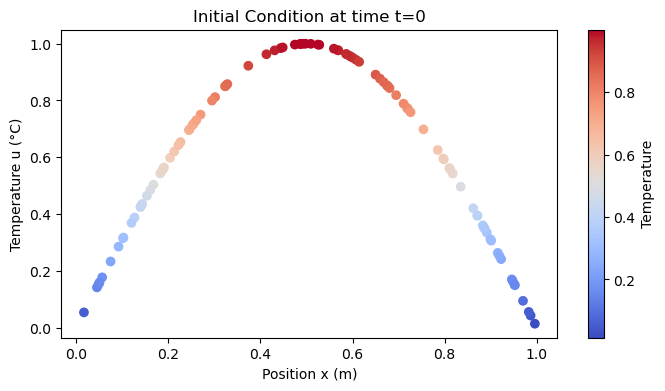

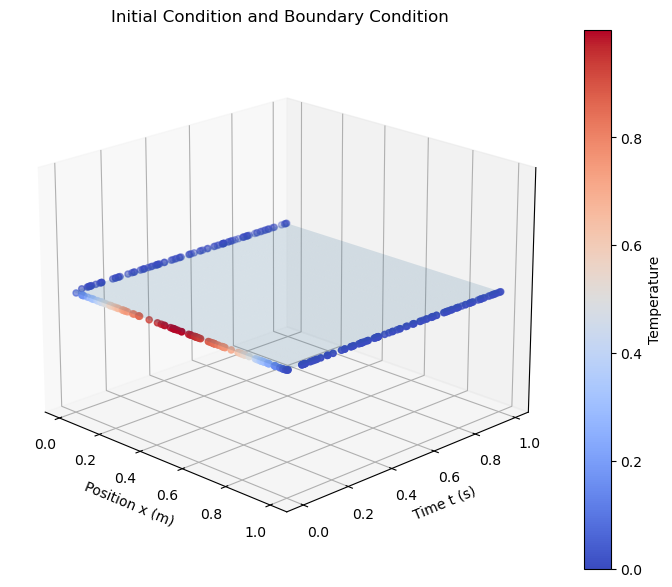

In [48]:
plot_IC_BC(num_domain_points, num_boundary_points, initial_condition=i_c_sin)

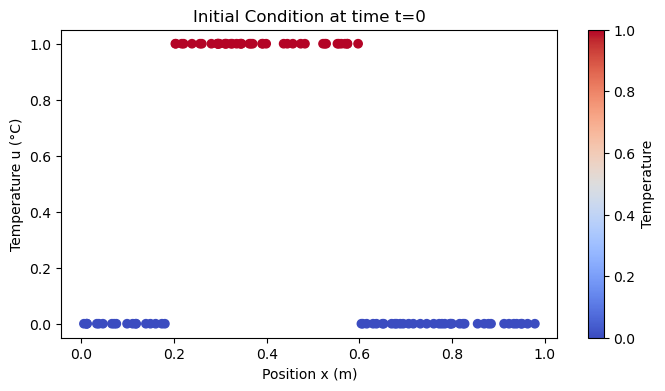

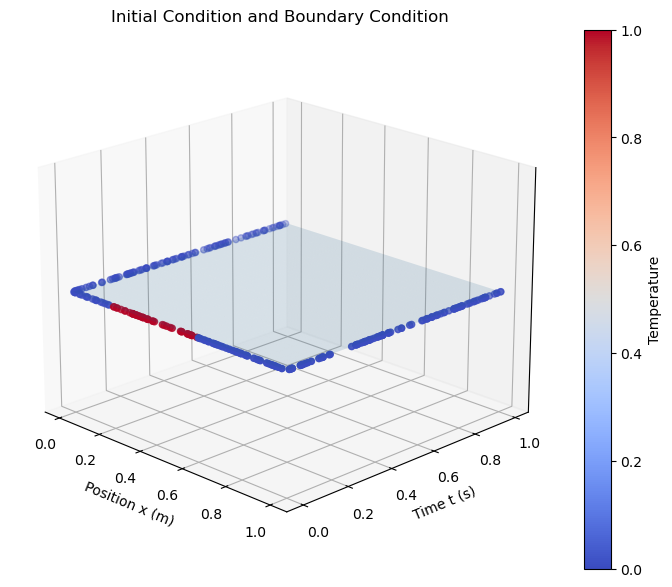

In [47]:

plot_IC_BC(num_domain_points, num_boundary_points, initial_condition=i_c_block)

In [5]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN,self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2,64),
            nn.Tanh(),
            nn.Linear(64,64),
            nn.Tanh(),
            nn.Linear(64,1)
        )
    def forward(self,x):
        return self.net(x)

In [6]:
def pde(x,t,model):
    input_data = torch.cat([x,t],dim=1)
    u = model(input_data)
    alpha= 0.1

    u_x = torch.autograd.grad(u, x,grad_outputs= torch.ones_like(u), create_graph= True, retain_graph=True)[0]
    u_xx = torch.autograd.grad(u_x,x,grad_outputs= torch.ones_like(u_x), create_graph= True, retain_graph=True)[0]
    u_t = torch.autograd.grad(u,t,grad_outputs= torch.ones_like(u), create_graph= True, retain_graph=True)[0]
    heat_eq_residual = alpha * u_xx - u_t
    return heat_eq_residual

In [7]:
def train_PINN(model, num_iterations, num_domain_points, num_boundary_points, initial_condition=i_c_sin,
               loss_weights = {'ic': 1, 'bc': 1, 'pde': 1},patience = 0.0001, print_loss = True):
    
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    ic_losses = []
    bc_losses = []
    pde_losses = []
    total_losses = []
    w_ic = loss_weights['ic']
    w_bc = loss_weights['bc']
    w_pde = loss_weights['pde']
    
    for  iteration in range(num_iterations):
        optimizer.zero_grad()

        x_domain, t_domain= generate_domain_points(num_domain_points)
        
        x_boundary, t_boundary, u_boundary = generate_boundary_data(num_boundary_points, boundary_value=0)
        
        x_initial, t_initial, u_initial = generate_initial_data(num_boundary_points, initial_condition)
        
        residual = pde(x_domain,t_domain,model)
        
        ic_loss= nn.MSELoss()(u_initial, model(torch.cat([x_initial, t_initial], dim=1))) * w_ic
        bc_loss = nn.MSELoss()(u_boundary, model(torch.cat([x_boundary, t_boundary], dim=1))) * w_bc
        pde_loss = nn.MSELoss()(residual, torch.zeros_like(residual)) * w_pde
        loss = ic_loss + bc_loss + pde_loss
        loss.backward()
        optimizer.step()

        # Accumulate losses
        ic_losses.append(ic_loss.item())
        bc_losses.append(bc_loss.item())
        pde_losses.append(pde_loss.item())
        total_losses.append(loss.item())

    
        # Print loss every 100 iterations and check for early stopping
        if iteration % 100 ==0:
            if print_loss:
                print("iter", iteration, "total_loss", f"{loss.item():.3f}", "ic_loss", f"{ic_loss.item():.4f}", "bc_loss", f"{bc_loss.item():.4f}", "pde_loss", f"{pde_loss.item():.4f}")

            # Early stopping when the avrage loss over the last 10 iterations is not changing
            diff_losses = (np.mean(total_losses[-100:]) - np.mean(total_losses[-50:]))
            if iteration > 0 and diff_losses < patience:
                print("Early stopping at iteration", iteration)
                # insert all losses to a dataframe
                df = pd.DataFrame({'ic_loss': ic_losses, 'bc_loss': bc_losses, 'pde_loss': pde_losses, 'total_loss': total_losses})
                return df
            
            
    # insert all losses to a dataframe
    df = pd.DataFrame({'ic_loss': ic_losses, 'bc_loss': bc_losses, 'pde_loss': pde_losses, 'total_loss': total_losses})
    return df


In [8]:
def plot_losses(df):
    plt.figure(figsize=(10, 6))
    plt.plot(df['total_loss'], label='Total Loss')
    plt.plot(df['ic_loss'], label='IC Loss')
    plt.plot(df['bc_loss'], label='BC Loss')
    plt.plot(df['pde_loss'], label='PDE Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Losses')
    plt.legend()
    plt.show()


iter 0 total_loss 0.611 ic_loss 0.6063 bc_loss 0.0045 pde_loss 0.0004
iter 100 total_loss 0.323 ic_loss 0.2212 bc_loss 0.0899 pde_loss 0.0116
iter 200 total_loss 0.155 ic_loss 0.1091 bc_loss 0.0287 pde_loss 0.0167
iter 300 total_loss 0.091 ic_loss 0.0528 bc_loss 0.0343 pde_loss 0.0035
iter 400 total_loss 0.076 ic_loss 0.0539 bc_loss 0.0190 pde_loss 0.0032
iter 500 total_loss 0.067 ic_loss 0.0509 bc_loss 0.0136 pde_loss 0.0028
Early stopping at iteration 500


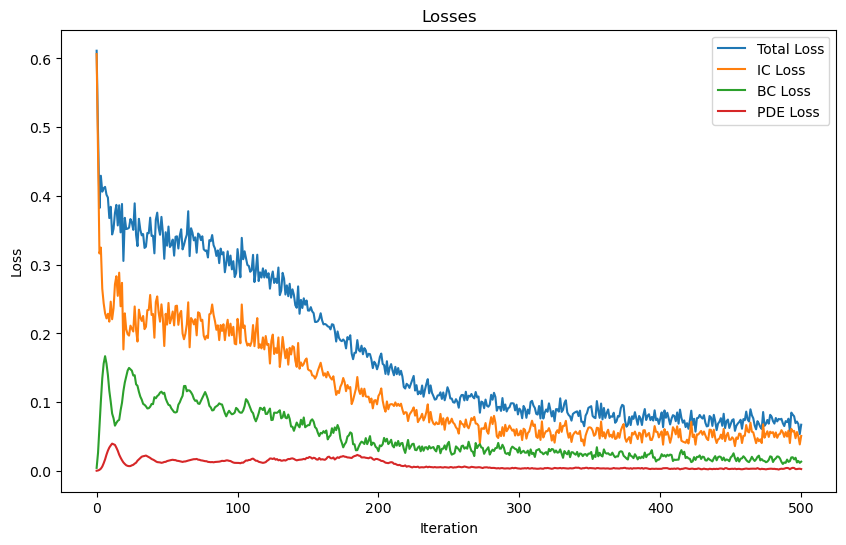

In [11]:
model = PINN()
losses = train_PINN(model,
                    num_iterations = 5000,
                    num_domain_points = 1000,
                    num_boundary_points = 100,
                    initial_condition=i_c_block,
                    loss_weights= {'ic': 1, 'bc': 1, 'pde': 1},
                    patience=0.001)
plot_losses(losses)

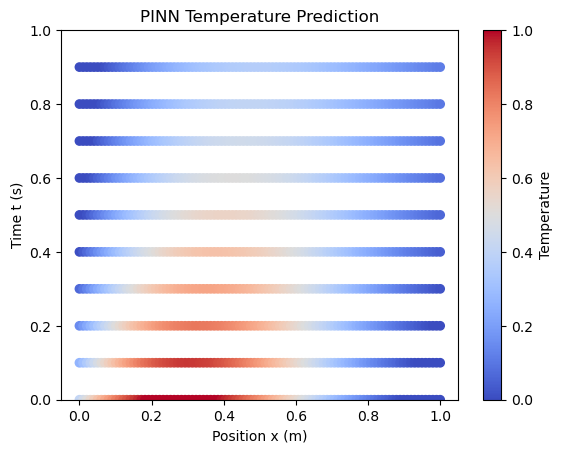

In [12]:
num_time_steps = 10
x_plot = []
t_plot = []
u_pred = []
with torch.no_grad():
    x_vals = torch.linspace(0,1,100)
    for t in range(num_time_steps):
        t_val = torch.ones_like(x_vals) * t/num_time_steps
        input_data = torch.stack([x_vals.flatten(),t_val.flatten()], dim=1)
        solution = model(input_data)
        x_plot.append(x_vals)
        t_plot.append(t_val)
        u_pred.append(solution)

# Convert to numpy and flatten all arrays
x_plot = torch.cat(x_plot).numpy()
t_plot = torch.cat(t_plot).numpy()
u_pred_np = torch.cat(u_pred).numpy()

# Plot
plt.scatter(x_plot, t_plot, c=u_pred_np, cmap='coolwarm')
plt.clim(0, 1)
plt.ylim(0, 1)
plt.xlabel('Position x (m)')
plt.ylabel('Time t (s)')
plt.title('PINN Temperature Prediction')
plt.colorbar(label='Temperature')
plt.show()